In [1]:
# Import libraries
import psycopg2
import getpass
import matplotlib.pyplot as plt
import numpy as np
import os.path
import time

In [2]:
# load the data
_data = np.load('res/admission.npy', allow_pickle=True).tolist()
adm_labels = _data['adm_labels']
all_adm = _data['all_adm']
first_adm = _data['first_adm']
adult_first_adm = _data['adult_first_adm']
print("Loaded!")

Loaded!


In [3]:
# Create a database connection
user = 'postgres'
host = 'localhost'
port = '5433'
dbname = 'mimic'
schema = 'mimiciii'

In [4]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path TO {}'.format(schema))
con.commit()
print("Connected!")

Password: ··········


Connected!


In [5]:
start = time.time()

# Select serum bicarb measurements
query = \
"""
SELECT subject_id, hadm_id, hadm_id, itemid, charttime, valuenum, valueuom
FROM labevents
WHERE itemid = 50882
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
serum_bicarb = np.array(data)

end = time.time()

# Print run time
print("This query took {} seconds".format(round((end-start),2)))

This query took 6.38 seconds


In [6]:
# Select the different units
query = \
"""
SELECT DISTINCT(valueuom)
FROM labevents
WHERE itemid = 50882
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
units = np.array(data)

# Display the units
print("Units:")
print(units)

Units:
[[None]
 ['mEq/L']]


In [7]:
# Check how many serum bicarb measurements are in the data set
print("No. of bicarb measurements: {}".format(np.shape(serum_bicarb)[0]))
print("No. of 'None' values: {} ({}%)".format(sum(x is None for x in serum_bicarb[:,5]), round(sum(x is None for x in serum_bicarb[:,5])/np.shape(serum_bicarb)[0],4)))

No. of bicarb measurements: 780648
No. of 'None' values: 209 (0.0003%)


In [8]:
print("Shape of serum_bicarb before removing None values: {}".format(np.shape(serum_bicarb)))

# Remove None values
serum_bicarb = serum_bicarb[~np.isnan(serum_bicarb[:,5].astype(float))]

print("Shape of serum_bicarb after removing None values: {}".format(np.shape(serum_bicarb)))

Shape of serum_bicarb before removing None values: (780648, 7)
Shape of serum_bicarb after removing None values: (780439, 7)


In [9]:
# Select data for hospital admission ID 145834 only
bicarb = serum_bicarb[serum_bicarb[:,1]==145834]

In [10]:
# Sort measurements by time
bicarb = bicarb[bicarb[:,4].argsort()]
bicarb[:,4] = bicarb[:,4] - adult_first_adm[:,-1][adult_first_adm[:,1]==145834] # convert raw times to time since admission
for i in range(len(bicarb[:,4])):
    bicarb[:,4][i] = bicarb[:,4][i].total_seconds()/(60*60)

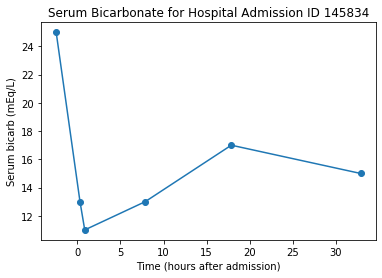

In [11]:
# Plot bicarb data for hospital admission ID 145834
hrs = 48 # select how many hours post admission to display
plt.plot(bicarb[:,4][bicarb[:,4]<=hrs], bicarb[:,5][bicarb[:,4]<=hrs], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('Serum bicarb (mEq/L)')
plt.title('Serum Bicarbonate for Hospital Admission ID 145834')
plt.show()

In [12]:
print("No. of measurements in first {} hours: {}".format(hrs,len(bicarb[:,4][bicarb[:,4]<=hrs])))
print("Total no. of measurements: {}".format(len(bicarb[:,4])))

No. of measurements in first 48 hours: 6
Total no. of measurements: 16


In [13]:
# Get mean bicarb for each hour
processed_bicarb = np.zeros((hrs,2))
for i in range(hrs):
    bicarb_values = bicarb[:,5][np.logical_and(bicarb[:,4]>=i, bicarb[:,4]<(i+1))]
    x = 1
    while len(bicarb_values) == 0:
        bicarb_values = bicarb[:,5][np.logical_and(bicarb[:,4]>=(i-x), bicarb[:,4]<(i+1+x))]
        x+=1
    mean_bicarb = np.mean(bicarb_values)
    processed_bicarb[i,0] = i+1
    processed_bicarb[i,1] = mean_bicarb

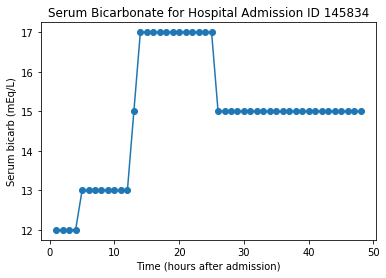

In [14]:
# Plot the processed bicarb data for hospital admission ID 145834
plt.plot(processed_bicarb[:,0], processed_bicarb[:,1], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('Serum bicarb (mEq/L)')
plt.title('Serum Bicarbonate for Hospital Admission ID 145834')
plt.show()

In [15]:
# Initialise a 3D numpy array for 24 hour measurements
m = len(adult_first_adm) # number of patients
bicarb_24h = np.zeros((m, hrs+1, 1))

In [16]:
# Create processed 24 hour bicarb time series for every patient
start = time.time()

for i in range(m):
    
    # Define hospital admission ID number
    admission_id = adult_first_adm[i,1]
    
    # Select data for hospital admission ID
    bicarb = serum_bicarb[serum_bicarb[:,1]==admission_id]
    
    # Account for patients with no bicarb measurements
    if len(bicarb) == 0:
        processed_bicarb = np.zeros((hrs,1))
        
    else:
    
        # Sort measurements by time
        admit_time = adult_first_adm[i,-1]
        bicarb = bicarb[bicarb[:,4].argsort()]
        bicarb[:,4] = bicarb[:,4] - admit_time # convert raw times to time since admission
        for j in range(len(bicarb[:,4])):
            bicarb[:,4][j] = bicarb[:,4][j].total_seconds()/(60*60)
    
        # Get mean bicarb for each hour
        processed_bicarb = np.zeros((hrs,1))
        for k in range(24):
            bicarb_values = bicarb[:,5][np.logical_and(bicarb[:,4]>=k, bicarb[:,4]<(k+1))]
            x = 1
            while len(bicarb_values) == 0:
                bicarb_values = bicarb[:,5][np.logical_and(bicarb[:,4]>=(k-x), bicarb[:,4]<(k+1+x))]
                x+=1
            mean_bicarb = np.mean(bicarb_values)
            processed_bicarb[k] = mean_bicarb
    
    # Store in bicarb_24h
    bicarb_24h[i,0,:] = admission_id
    bicarb_24h[i,1:,:] = processed_bicarb
    
    # Print progress
    if (i+1) % 1000 == 0:
        print("{}% complete ({}/{})".format(round((i+1)/m*100,2), i+1, m))

end = time.time()

# Evaluate run time
print("This took {} minutes".format(round((end-start)/60,2)))

2.59% complete (1000/38549)


KeyboardInterrupt: 

In [ ]:
bicarb_labels = ["subject_id", "hadm_id", "hadm_id", "itemid", "charttime", "valuenum", "valueuom"]

# Save to bicarb.npy
if not os.path.exists('./res'):
    os.makedirs('./res')

tosave = {'bicarb_labels': bicarb_labels, 'serum_bicarb': serum_bicarb, 'bicarb_24h': bicarb_24h}
np.save('res/bicarb.npy',tosave)
print("Saved!")